Image: /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images/IMG_128.jpg, Annotations: 41 points


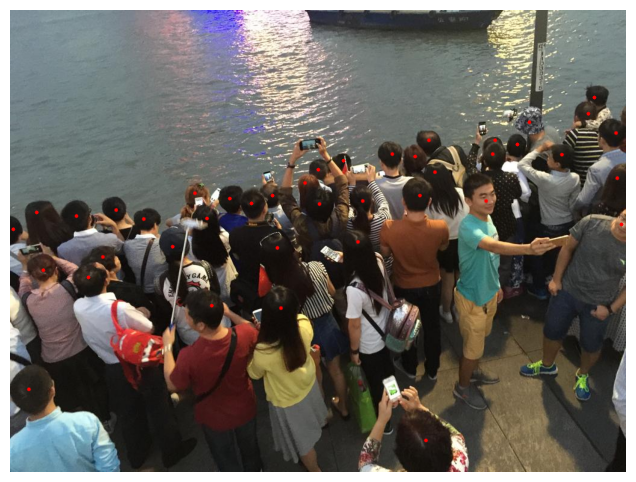

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
import torch

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.gt_dir = os.path.join(root_dir, "ground-truth")
        self.image_paths = [os.path.join(self.image_dir, img)
                            for img in os.listdir(self.image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path).replace(".jpg", ".mat")
        gt_filename = "GT_" + filename
        gt_path = os.path.join(self.gt_dir, gt_filename)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found for {img_path}")

        image = Image.open(img_path).convert("RGB")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]

        if self.transform:
            image = self.transform(image)

        return image, points.tolist(), img_path

def visualize_sample(img_path, points, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for point in points:
        x, y = int(point[0]), int(point[1])
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def custom_collate(batch):
    images, points, paths = zip(*batch)
    return torch.stack(images, 0), list(points), list(paths)

if __name__ == "__main__":
    dataset_path = r"/content/drive/MyDrive/ShanghaiTech/part_B/train_data"
    dataset = CrowdDataset(root_dir=dataset_path, transform=transform)

    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

    for img_tensor, points, img_path in dataloader:
        sample_img_path = img_path[0]
        sample_points = points[0]
        print(f"Image: {sample_img_path}, Annotations: {len(sample_points)} points")

        visualize_sample(sample_img_path, sample_points, save_path="visualizations/sample.png")
        break

Using device: cpu
CSRNet model initialized
Model parameters: 16,268,865

Testing dataset loading with density map generation...
Image: /content/drive/MyDrive/ShanghaiTech/part_B/train_data/images/IMG_92.jpg
Annotations: 36 points
Image tensor shape: torch.Size([3, 512, 512])
Density map shape: (512, 512)
Density map sum: 32.68


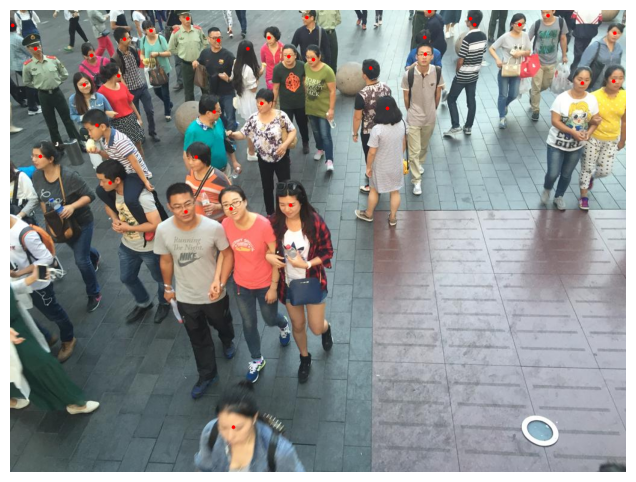

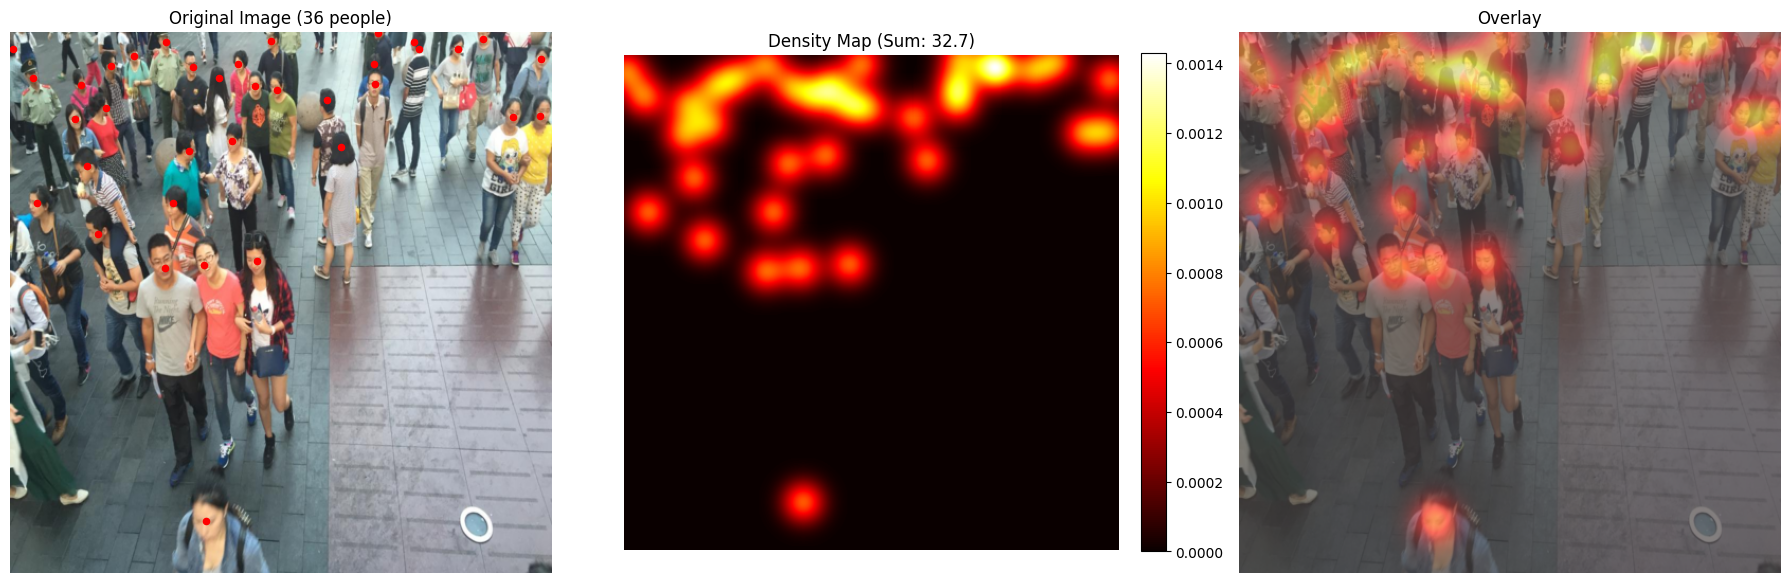


Testing CSRNet forward pass...
Input shape: torch.Size([4, 3, 512, 512])
Output shape: torch.Size([4, 1, 64, 64])
Predicted count: -587.50
Ground truth count: 61


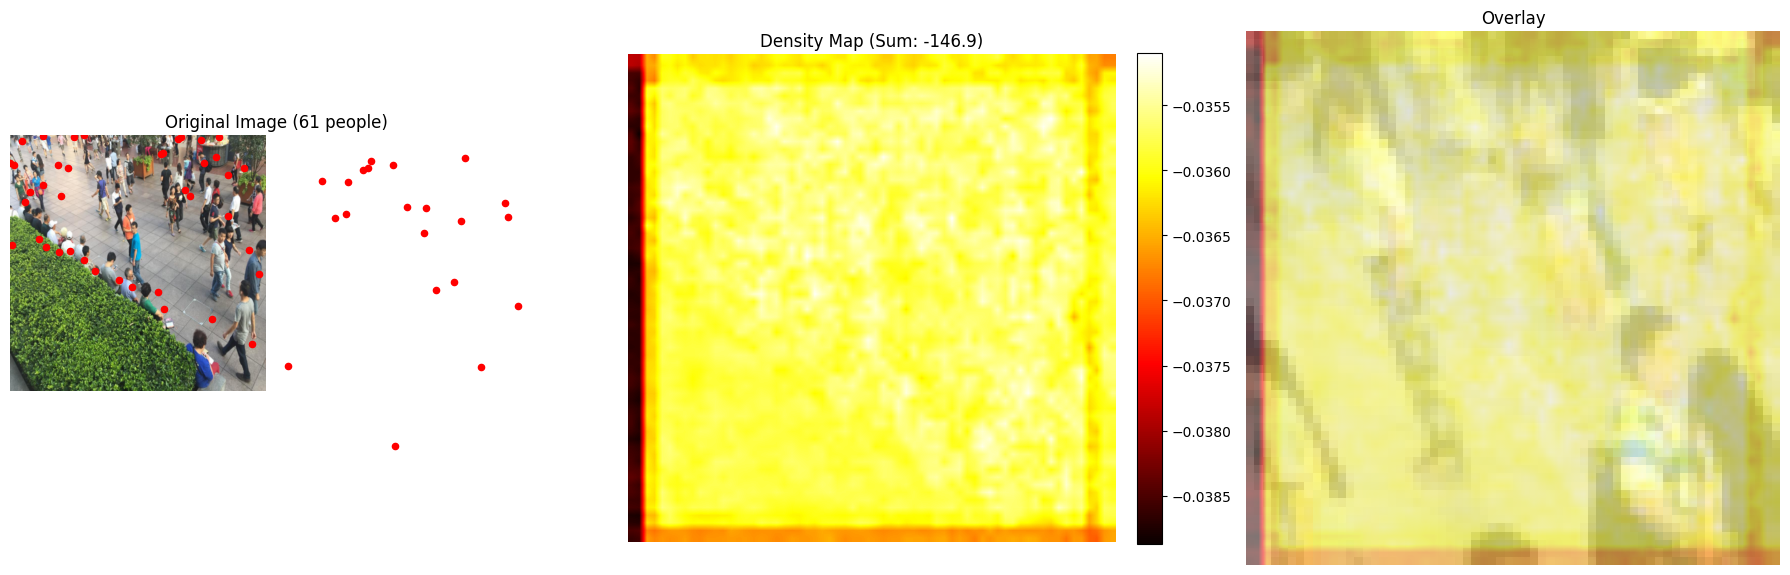

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
import torch
import torch.nn as nn
from torchvision import models

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=True)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])
        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2), nn.ReLU(),
            nn.Conv2d(64, 1, 1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.gt_dir = os.path.join(root_dir, "ground-truth")
        self.image_paths = [os.path.join(self.image_dir, img)
                            for img in os.listdir(self.image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path).replace(".jpg", ".mat")
        gt_filename = "GT_" + filename
        gt_path = os.path.join(self.gt_dir, gt_filename)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found for {img_path}")

        image = Image.open(img_path).convert("RGB")

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]

        if self.transform:
            image = self.transform(image)

        return image, points.tolist(), img_path

def generate_density_map(points, image_shape, sigma=15):

    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    for point in points:
        x, y = int(point[0]), int(point[1])
        if 0 <= x < w and 0 <= y < h:

            kernel_size = int(6 * sigma + 1)
            if kernel_size % 2 == 0:
                kernel_size += 1


            xx, yy = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
            center = kernel_size // 2


            gaussian = np.exp(-((xx - center) ** 2 + (yy - center) ** 2) / (2 * sigma ** 2))
            gaussian = gaussian / (2 * np.pi * sigma ** 2)

            x_min = max(0, x - center)
            x_max = min(w, x + center + 1)
            y_min = max(0, y - center)
            y_max = min(h, y + center + 1)

            kx_min = max(0, center - x)
            kx_max = kx_min + (x_max - x_min)
            ky_min = max(0, center - y)
            ky_max = ky_min + (y_max - y_min)

            density_map[y_min:y_max, x_min:x_max] += gaussian[ky_min:ky_max, kx_min:kx_max]

    return density_map

def visualize_sample(img_path, points, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for point in points:
        x, y = int(point[0]), int(point[1])
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def visualize_density_map(image_tensor, density_map, points, save_path=None):

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor * std + mean
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(image)
    for point in points:
        x, y = int(point[0]), int(point[1])
        axes[0].scatter(x, y, c='red', s=20, marker='o')
    axes[0].set_title(f'Original Image ({len(points)} people)')
    axes[0].axis('off')

    im = axes[1].imshow(density_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Density Map (Sum: {density_map.sum():.1f})')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(image, alpha=0.7)
    axes[2].imshow(density_map, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)

    plt.show()

def custom_collate(batch):
    images, points, paths = zip(*batch)
    return torch.stack(images, 0), list(points), list(paths)

def test_model_forward(model, dataloader, device):
    """
    Test forward pass of CSRNet model
    """
    model.eval()
    with torch.no_grad():
        for img_tensor, points, img_paths in dataloader:
            img_tensor = img_tensor.to(device)

            print(f"Input shape: {img_tensor.shape}")

            output = model(img_tensor)

            print(f"Output shape: {output.shape}")
            print(f"Predicted count: {output.sum().item():.2f}")
            print(f"Ground truth count: {len(points[0])}")


            sample_output = output[0, 0].cpu().numpy()
            sample_image = img_tensor[0].cpu()
            sample_points = points[0]

            visualize_density_map(sample_image, sample_output, sample_points,
                                save_path="visualizations/model_output.png")

            break

if __name__ == "__main__":
    dataset_path = r"/content/drive/MyDrive/ShanghaiTech/part_B/train_data"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    dataset = CrowdDataset(root_dir=dataset_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=custom_collate)

    model = CSRNet()
    model.to(device)
    print("CSRNet model initialized")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    print("\nTesting dataset loading with density map generation...")
    for img_tensor, points, img_path in dataloader:
        sample_img_tensor = img_tensor[0]
        sample_points = points[0]
        sample_img_path = img_path[0]

        print(f"Image: {sample_img_path}")
        print(f"Annotations: {len(sample_points)} points")
        print(f"Image tensor shape: {sample_img_tensor.shape}")

        original_image = Image.open(sample_img_path)
        scale_x = 512 / original_image.size[0]
        scale_y = 512 / original_image.size[1]

        scaled_points = [[p[0] * scale_x, p[1] * scale_y] for p in sample_points]
        density_map = generate_density_map(scaled_points, (512, 512), sigma=15)

        print(f"Density map shape: {density_map.shape}")
        print(f"Density map sum: {density_map.sum():.2f}")

        visualize_sample(sample_img_path, sample_points,
                        save_path="visualizations/sample_with_points.png")

        visualize_density_map(sample_img_tensor, density_map, scaled_points,
                            save_path="visualizations/density_map_visualization.png")

        break

    print("\nTesting CSRNet forward pass...")
    test_model_forward(model, dataloader, device)

Using device: cuda
Loading datasets...
Training samples: 400
Test samples: 316
Training subset: 320
Validation subset: 80
CSRNet model initialized
Model parameters: 16,268,865

Testing data loading...
Batch - Images: torch.Size([4, 3, 512, 512]), Density maps: torch.Size([4, 512, 512])
Sample counts: [174, 159, 30]
Density map sums: ['169.06', '154.50', '26.96']


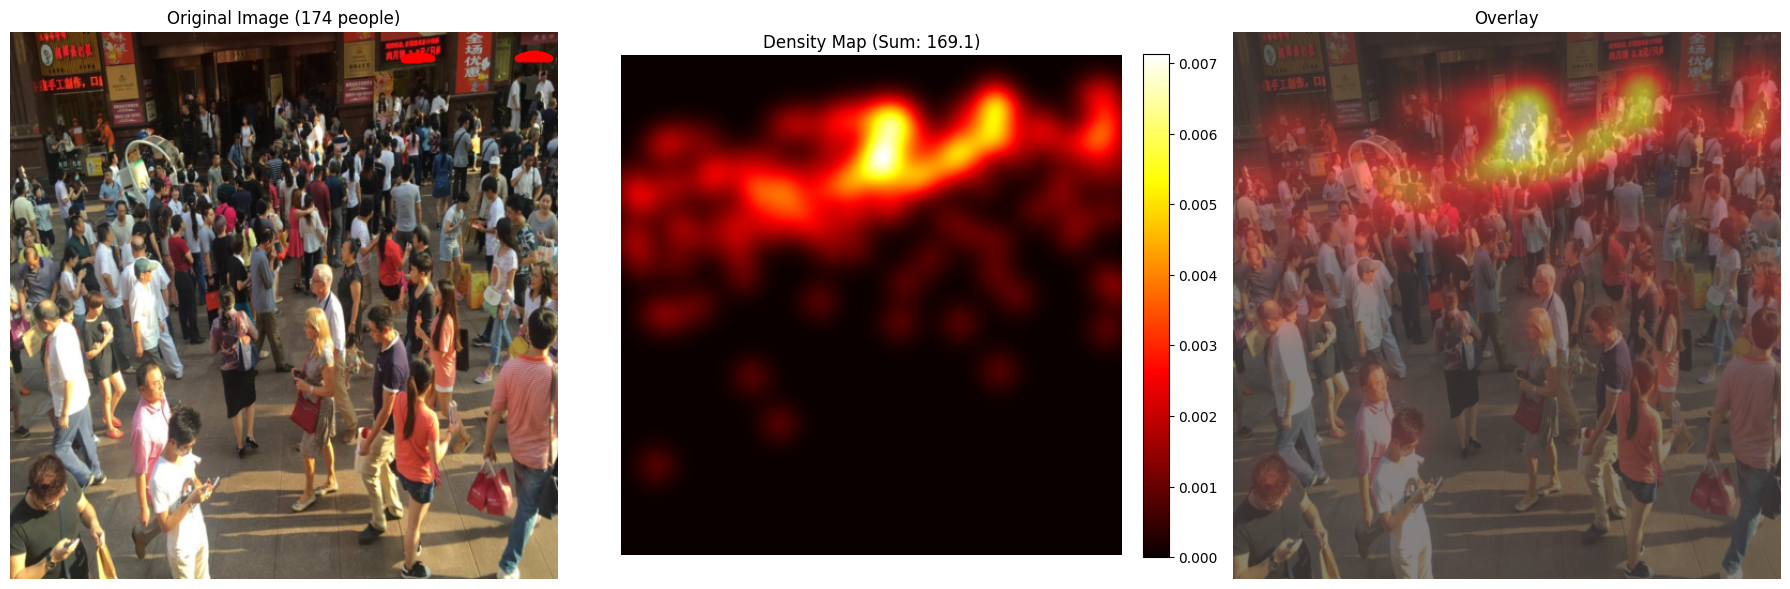


STARTING TRAINING
Starting training for 5 epochs...
Device: cuda


Epoch 1/5 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.96it/s, Loss=0.000003, MAE=158.79]


New best model saved! Val MAE: 158.79
Epoch [1/5]
Train Loss: 0.000007
Val Loss: 0.000003
Val MAE: 158.79
Learning Rate: 1.00e-05
--------------------------------------------------


Epoch 2/5 [Val]: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s, Loss=0.000002, MAE=87.00]


New best model saved! Val MAE: 87.00
Epoch [2/5]
Train Loss: 0.000002
Val Loss: 0.000002
Val MAE: 87.00
Learning Rate: 1.00e-05
--------------------------------------------------


Epoch 3/5 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s, Loss=0.000002, MAE=81.59]


New best model saved! Val MAE: 81.59
Epoch [3/5]
Train Loss: 0.000002
Val Loss: 0.000002
Val MAE: 81.59
Learning Rate: 1.00e-05
--------------------------------------------------


Epoch 4/5 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.94it/s, Loss=0.000002, MAE=82.73]


Epoch [4/5]
Train Loss: 0.000002
Val Loss: 0.000002
Val MAE: 82.73
Learning Rate: 1.00e-05
--------------------------------------------------


Epoch 5/5 [Val]: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s, Loss=0.000002, MAE=83.79]


Epoch [5/5]
Train Loss: 0.000002
Val Loss: 0.000002
Val MAE: 83.79
Learning Rate: 1.00e-05
--------------------------------------------------


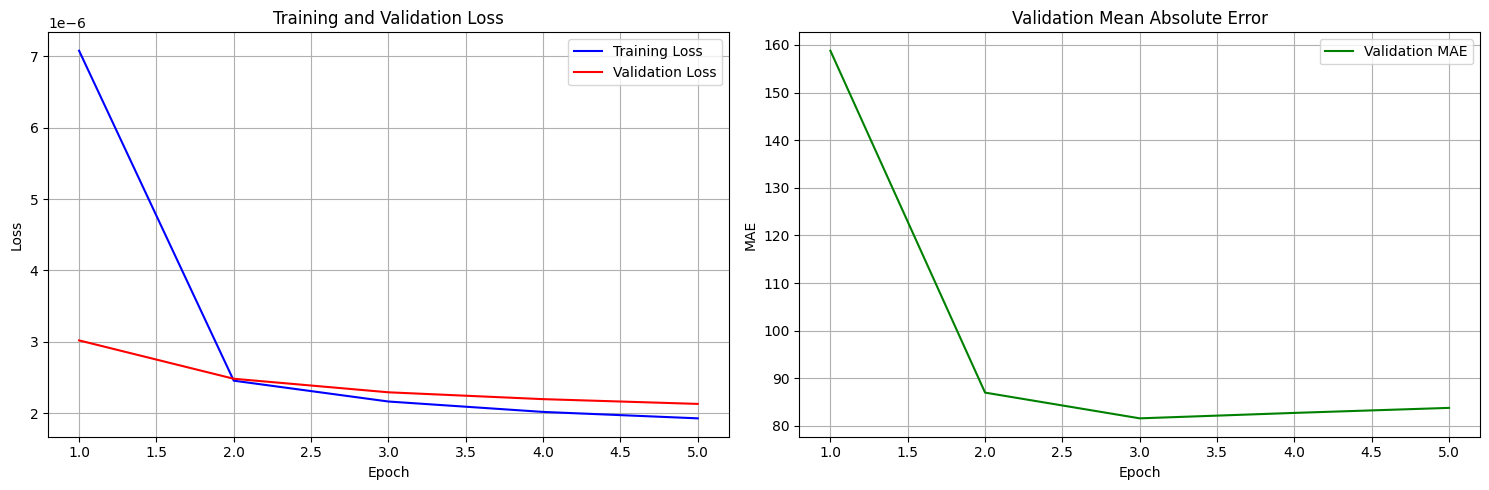


Loading best model for evaluation...
Loaded model from epoch 2 with Val MAE: 81.59

EVALUATING ON TEST SET


Evaluating: 100%|██████████| 79/79 [04:36<00:00,  3.50s/it]



Evaluation Results:
MAE: 70.53
MSE: 11575.99
RMSE: 107.59


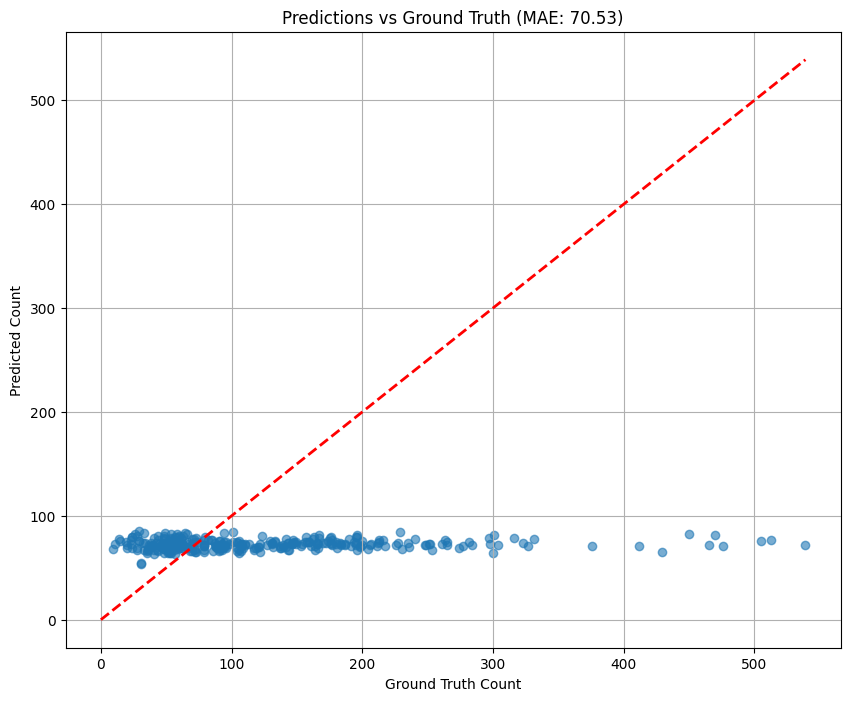


Final Test Results:
Test MAE: 70.53
Test MSE: 11575.99
Test RMSE: 107.59

Training completed! Models and visualizations saved.


In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import time
from tqdm import tqdm

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        vgg = models.vgg16_bn(pretrained=load_weights)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:33])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True)
        )

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x

class CrowdDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, "images")
        self.gt_dir = os.path.join(root_dir, "ground-truth")
        self.image_paths = [os.path.join(self.image_dir, img)
                            for img in os.listdir(self.image_dir) if img.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path).replace(".jpg", ".mat")
        gt_filename = "GT_" + filename
        gt_path = os.path.join(self.gt_dir, gt_filename)

        if not os.path.exists(gt_path):
            raise FileNotFoundError(f"Ground truth file not found for {img_path}")

        image = Image.open(img_path).convert("RGB")
        original_size = image.size  # (width, height)

        mat = sio.loadmat(gt_path)
        points = mat["image_info"][0, 0][0, 0][0]

        if self.transform:
            image = self.transform(image)

        # Scale points to match transformed image size (512x512)
        scale_x = 512 / original_size[0]
        scale_y = 512 / original_size[1]
        scaled_points = [[p[0] * scale_x, p[1] * scale_y] for p in points]

        # Generate density map
        density_map = generate_density_map(scaled_points, (512, 512), sigma=15)
        density_map = torch.from_numpy(density_map).float()

        return image, density_map, len(points), img_path

def generate_density_map(points, image_shape, sigma=15):
    """
    Generate Gaussian density map from point annotations
    Args:
        points: List of [x, y] coordinates
        image_shape: (height, width) of the target density map
        sigma: Standard deviation for Gaussian kernel
    """
    h, w = image_shape
    density_map = np.zeros((h, w), dtype=np.float32)

    if len(points) == 0:
        return density_map

    for point in points:
        x, y = int(point[0]), int(point[1])
        if 0 <= x < w and 0 <= y < h:
            # Create Gaussian kernel
            kernel_size = int(6 * sigma + 1)
            if kernel_size % 2 == 0:
                kernel_size += 1

            # Generate coordinate grids
            xx, yy = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
            center = kernel_size // 2

            # Calculate Gaussian
            gaussian = np.exp(-((xx - center) ** 2 + (yy - center) ** 2) / (2 * sigma ** 2))
            gaussian = gaussian / (2 * np.pi * sigma ** 2)  # Normalize

            # Calculate bounds for placing the kernel
            x_min = max(0, x - center)
            x_max = min(w, x + center + 1)
            y_min = max(0, y - center)
            y_max = min(h, y + center + 1)

            # Calculate kernel bounds
            kx_min = max(0, center - x)
            kx_max = kx_min + (x_max - x_min)
            ky_min = max(0, center - y)
            ky_max = ky_min + (y_max - y_min)

            # Add Gaussian to density map
            density_map[y_min:y_max, x_min:x_max] += gaussian[ky_min:ky_max, kx_min:kx_max]

    return density_map

def visualize_sample(img_path, points, save_path=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for point in points:
        x, y = int(point[0]), int(point[1])
        cv2.circle(img, (x, y), 3, (255, 0, 0), -1)

    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis("off")
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

def visualize_density_map(image_tensor, density_map, points, save_path=None):
    """
    Visualize image, density map, and ground truth points
    """
    # Denormalize image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image = image_tensor * std + mean
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image with points
    axes[0].imshow(image)
    for point in points:
        x, y = int(point[0]), int(point[1])
        axes[0].scatter(x, y, c='red', s=20, marker='o')
    axes[0].set_title(f'Original Image ({len(points)} people)')
    axes[0].axis('off')

    # Density map
    im = axes[1].imshow(density_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title(f'Density Map (Sum: {density_map.sum():.1f})')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)

    # Overlay
    axes[2].imshow(image, alpha=0.7)
    axes[2].imshow(density_map, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[2].set_title('Overlay')
    axes[2].axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=150)

    plt.show()

def custom_collate(batch):
    images, density_maps, counts, paths = zip(*batch)
    return torch.stack(images, 0), torch.stack(density_maps, 0), list(counts), list(paths)

def train_model(model, train_loader, val_loader, device, num_epochs=5, lr=1e-5):
    """
    Training function for CSRNet
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    val_losses = []
    val_maes = []

    best_val_mae = float('inf')
    best_model_path = 'best_csrnet_model.pth'

    print(f"Starting training for {num_epochs} epochs...")
    print(f"Device: {device}")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_batches = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for images, density_maps, counts, paths in train_pbar:
            images = images.to(device)
            density_maps = density_maps.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Resize output to match density map size if necessary
            if outputs.size() != density_maps.unsqueeze(1).size():
                outputs = F.interpolate(outputs, size=density_maps.shape[1:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, density_maps.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_batches += 1

            # Update progress bar
            avg_train_loss = train_loss / train_batches
            train_pbar.set_postfix({'Loss': f'{avg_train_loss:.6f}'})

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_batches = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, density_maps, counts, paths in val_pbar:
                images = images.to(device)
                density_maps = density_maps.to(device)

                outputs = model(images)

                # Resize output to match density map size if necessary
                if outputs.size() != density_maps.unsqueeze(1).size():
                    outputs = F.interpolate(outputs, size=density_maps.shape[1:], mode='bilinear', align_corners=False)

                loss = criterion(outputs, density_maps.unsqueeze(1))
                val_loss += loss.item()

                # Calculate MAE (Mean Absolute Error)
                pred_counts = outputs.sum(dim=(1, 2, 3)).cpu().numpy()
                gt_counts = np.array(counts)
                batch_mae = np.mean(np.abs(pred_counts - gt_counts))
                val_mae += batch_mae

                val_batches += 1

                # Update progress bar
                avg_val_loss = val_loss / val_batches
                avg_val_mae = val_mae / val_batches
                val_pbar.set_postfix({'Loss': f'{avg_val_loss:.6f}', 'MAE': f'{avg_val_mae:.2f}'})

        avg_val_loss = val_loss / val_batches
        avg_val_mae = val_mae / val_batches
        val_losses.append(avg_val_loss)
        val_maes.append(avg_val_mae)

        # Learning rate scheduling
        scheduler.step()

        # Save best model
        if avg_val_mae < best_val_mae:
            best_val_mae = avg_val_mae
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_mae': avg_val_mae,
                'val_loss': avg_val_loss
            }, best_model_path)
            print(f"New best model saved! Val MAE: {avg_val_mae:.2f}")

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {avg_train_loss:.6f}')
        print(f'Val Loss: {avg_val_loss:.6f}')
        print(f'Val MAE: {avg_val_mae:.2f}')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.2e}')
        print('-' * 50)

    # Plot training curves
    plot_training_curves(train_losses, val_losses, val_maes)

    return train_losses, val_losses, val_maes

def plot_training_curves(train_losses, val_losses, val_maes):
    """
    Plot training and validation curves
    """
    epochs = range(1, len(train_losses) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # MAE curve
    ax2.plot(epochs, val_maes, 'g-', label='Validation MAE')
    ax2.set_title('Validation Mean Absolute Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

def evaluate_model(model, test_loader, device):
    """
    Evaluate trained model
    """
    model.eval()
    total_mae = 0.0
    total_mse = 0.0
    num_samples = 0

    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, density_maps, counts, paths in tqdm(test_loader, desc='Evaluating'):
            images = images.to(device)
            density_maps = density_maps.to(device)

            outputs = model(images)

            # Resize output to match density map size if necessary
            if outputs.size() != density_maps.unsqueeze(1).size():
                outputs = F.interpolate(outputs, size=density_maps.shape[1:], mode='bilinear', align_corners=False)

            pred_counts = outputs.sum(dim=(1, 2, 3)).cpu().numpy()
            gt_counts = np.array(counts)

            predictions.extend(pred_counts)
            ground_truths.extend(gt_counts)

            # Calculate metrics
            mae = np.mean(np.abs(pred_counts - gt_counts))
            mse = np.mean((pred_counts - gt_counts) ** 2)

            total_mae += mae * len(counts)
            total_mse += mse * len(counts)
            num_samples += len(counts)

    avg_mae = total_mae / num_samples
    avg_mse = total_mse / num_samples
    avg_rmse = np.sqrt(avg_mse)

    print(f'\nEvaluation Results:')
    print(f'MAE: {avg_mae:.2f}')
    print(f'MSE: {avg_mse:.2f}')
    print(f'RMSE: {avg_rmse:.2f}')

    # Plot predictions vs ground truth
    plt.figure(figsize=(10, 8))
    plt.scatter(ground_truths, predictions, alpha=0.6)
    plt.plot([0, max(ground_truths)], [0, max(ground_truths)], 'r--', linewidth=2)
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Predicted Count')
    plt.title(f'Predictions vs Ground Truth (MAE: {avg_mae:.2f})')
    plt.grid(True)
    plt.savefig('predictions_vs_ground_truth.png', dpi=150, bbox_inches='tight')
    plt.show()

    return avg_mae, avg_mse, predictions, ground_truths

if __name__ == "__main__":
    # Configuration
    train_dataset_path = r"/content/drive/MyDrive/ShanghaiTech/part_B/train_data"
    test_dataset_path = r"/content/drive/MyDrive/ShanghaiTech/part_B/test_data"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training parameters
    batch_size = 4
    num_epochs = 5
    learning_rate = 1e-5

    print(f"Using device: {device}")

    # Create datasets
    print("Loading datasets...")
    train_dataset = CrowdDataset(root_dir=train_dataset_path, transform=transform)
    test_dataset = CrowdDataset(root_dir=test_dataset_path, transform=transform)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             collate_fn=custom_collate, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                            collate_fn=custom_collate, num_workers=2)

    # Split training data for validation (80% train, 20% val)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    train_subset_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                   collate_fn=custom_collate, num_workers=2)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                           collate_fn=custom_collate, num_workers=2)

    print(f"Training subset: {len(train_subset)}")
    print(f"Validation subset: {len(val_subset)}")

    # Initialize model
    model = CSRNet(load_weights=True)
    model.to(device)
    print("CSRNet model initialized")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Test data loading with a few samples
    print("\nTesting data loading...")
    for images, density_maps, counts, paths in train_loader:
        print(f"Batch - Images: {images.shape}, Density maps: {density_maps.shape}")
        print(f"Sample counts: {counts[:3]}")
        density_sums = [dm.sum().item() for dm in density_maps[:3]]
        print(f"Density map sums: {[f'{s:.2f}' for s in density_sums]}")

        # Visualize first sample
        sample_image = images[0]
        sample_density = density_maps[0]
        sample_count = counts[0]

        # For visualization, we need to convert back to points (approximate)
        density_np = sample_density.numpy()
        y_coords, x_coords = np.where(density_np > density_np.max() * 0.1)
        sample_points = [[x, y] for x, y in zip(x_coords, y_coords)]

        visualize_density_map(sample_image, density_np, sample_points[:sample_count],
                            save_path="visualizations/training_sample.png")
        break

    # Start training
    print("\n" + "="*50)
    print("STARTING TRAINING")
    print("="*50)

    train_losses, val_losses, val_maes = train_model(
        model, train_subset_loader, val_loader, device,
        num_epochs=num_epochs, lr=learning_rate
    )

    # Load best model for evaluation
    print("\nLoading best model for evaluation...")
    checkpoint = torch.load('best_csrnet_model.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with Val MAE: {checkpoint['val_mae']:.2f}")

    # Evaluate on test set
    print("\n" + "="*50)
    print("EVALUATING ON TEST SET")
    print("="*50)

    test_mae, test_mse, predictions, ground_truths = evaluate_model(model, test_loader, device)

    print(f"\nFinal Test Results:")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test MSE: {test_mse:.2f}")
    print(f"Test RMSE: {np.sqrt(test_mse):.2f}")

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'test_mae': test_mae,
        'test_mse': test_mse,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_maes': val_maes
    }, 'final_csrnet_model.pth')

    print("\nTraining completed! Models and visualizations saved.")